# Data Analysis
Analyze the dataset (identification.tar) provided to you and the images associated embeddings, and report TWO significant findings you believe will impact the model or system's performance.

#### Import necessary libraries

In [18]:
# Import all libraries necessary for analysis
import sys
sys.path.insert(1,'../')
from src.search.search import Measure
from pipeline import Pipeline, MULTI_IMAGE_GALLERY_STORAGE
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#### Precompute all embeddings for all models

In [19]:
# Precompute all embeddings for all 4 models
pipeline_064_018 = Pipeline(image_size=64, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_064_034 = Pipeline(image_size=64, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_224_018 = Pipeline(image_size=224, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_224_034 = Pipeline(image_size=224, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)

Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...


#### Calculate principal components of all embeddings for all 4 models

In [40]:
model_embeddings = {}
model_pca = {}
for image_size in [64, 224]:
    for arch in ['resnet_018', 'resnet_034']:
        model = f'model_size_{image_size:03}_{arch}'
        pattern = f'../storage/embeddings/{model}/*/*.npy'
        npy_files = glob(pattern)
        embeddings = np.zeros([len(npy_files), 256])
        for i in range(len(npy_files)):
            filename = npy_files[i]
            with open(filename, 'rb') as f:
                embeddings[i,:] = np.load(f).T

        X_reduced = PCA(n_components=2).fit_transform(embeddings)
        model_pca[model] = X_reduced
        model_embeddings[model] = embeddings

## 1. Model Differences

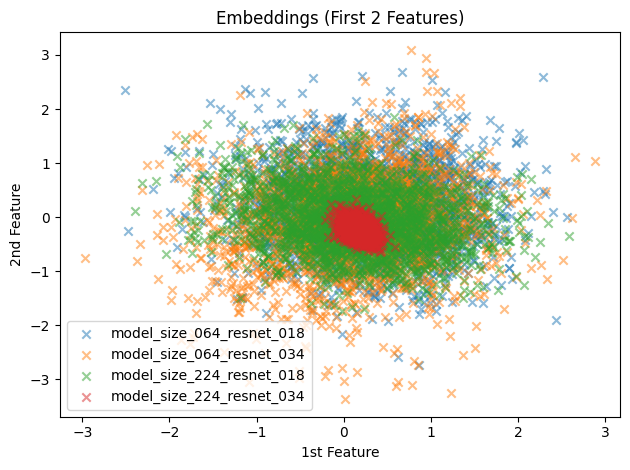

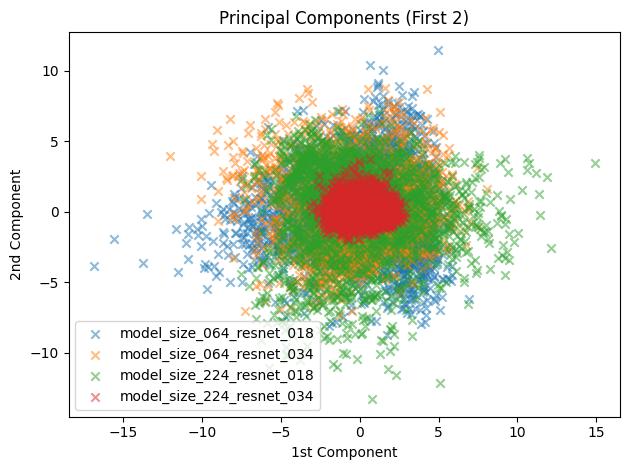

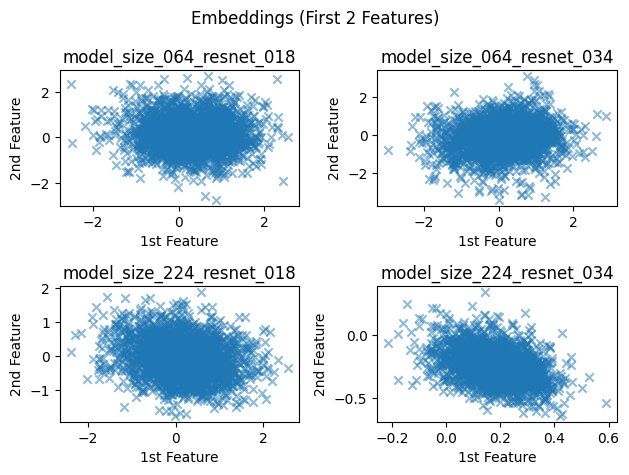

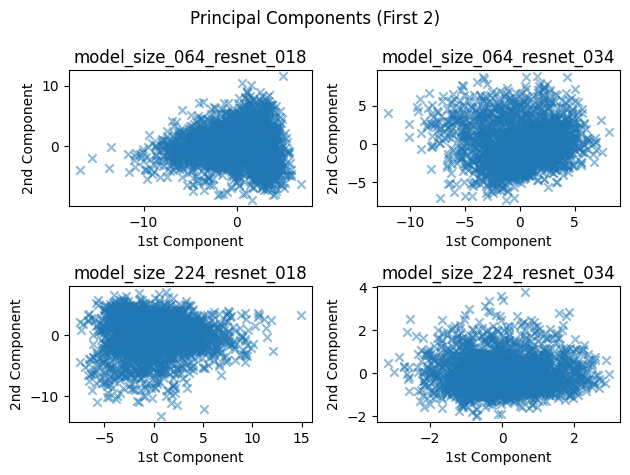

In [57]:
# Initialize plot axes
fig1, ax1 = plt.subplots() # Embeddings
fig2, ax2 = plt.subplots() # PCA
fig3, ax3 = plt.subplots(2,2) # Embeddings (subplots)
fig4, ax4 = plt.subplots(2,2) # PCA (subplots)

# Plot data
models = list(model_embeddings.keys())
for i in range(len(models)):
    m = models[i]
    ax1.scatter(model_embeddings[m][:,0], model_embeddings[m][:,1], label=m, marker='x', alpha=0.5)
    ax2.scatter(model_pca[m][:,0], model_pca[m][:,1], label=m, marker='x', alpha=0.5)
    ax3[i//2,i%2].scatter(model_embeddings[m][:,0], model_embeddings[m][:,1], label=m, marker='x', alpha=0.5)
    ax3[i//2,i%2].set_title(m)
    ax3[i//2,i%2].set_xlabel('1st Feature')
    ax3[i//2,i%2].set_ylabel('2nd Feature')
    ax4[i//2,i%2].scatter(model_pca[m][:,0], model_pca[m][:,1], label=m, marker='x', alpha=0.5)
    ax4[i//2,i%2].set_title(m)
    ax4[i//2,i%2].set_xlabel('1st Component')
    ax4[i//2,i%2].set_ylabel('2nd Component')

# Format plots
ax1.legend()
ax1.set_title('Embeddings (First 2 Features)')
ax1.set_xlabel('1st Feature')
ax1.set_ylabel('2nd Feature')
fig1.tight_layout()

ax2.legend()
ax2.set_title('Principal Components (First 2)')
ax2.set_xlabel('1st Component')
ax2.set_ylabel('2nd Component')
fig2.tight_layout()

fig3.suptitle('Embeddings (First 2 Features)')
fig3.tight_layout()

fig4.suptitle('Principal Components (First 2)')
fig4.tight_layout()

plt.show()


# 2. Cluster Differences

In [ ]:
# Find 3 people with multiple images
# Plot their embeddings & pca (all models)
# Calculate average inter- and intra- cluster distance (or other class separability measure)
# Table of cluster distances / model
# Display images of the people